In [2]:
from read_roi import read_roi_file, read_roi_zip
import skimage.io as io
import pydicom
import matplotlib.pyplot as plt
import numpy as np
from math import ceil, floor
import random
import os

from skimage.feature import hog
from sklearn.decomposition import PCA, FastICA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score,recall_score, precision_score

from detection_data import ims_T1, ims_T2, pos
from detection_data import read_pos_labels
from utils import rois_dict_to_axis, get_rois, find_rect, gmm
from utils import label_size, modify_label_size, input_size

train data: 
(36358, 36, 36, 1) float32
(36064, 36, 36, 1) float32
(36358,) int64
(36064,) int64

validation data: 
(13916, 36, 36, 1) float32
(13916, 36, 36, 1) float32
(13916,) int64
(13916,) int64


# 准备数据

In [3]:
if_modify_size = True
if_normalized = True

dir_labels = r'D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\positive ROI\T1 SAG'
dir_data = r'D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\IRM_process'
train_pos_labels_T1, val_pos_labels_T1 = read_pos_labels(dir_labels, dir_data, 1,if_modify_size,if_normalized)
             
train_data = train_pos_labels_T1[:100]
val_data = np.concatenate((train_pos_labels_T1[101:],val_pos_labels_T1))
im_shape = train_data.shape[1:]

print(train_data.shape)
print(val_data.shape)

(100, 42, 42)
(412, 42, 42)


# 模型：找mask

(10, 42, 42)
(42, 42) 0.7576967953949666


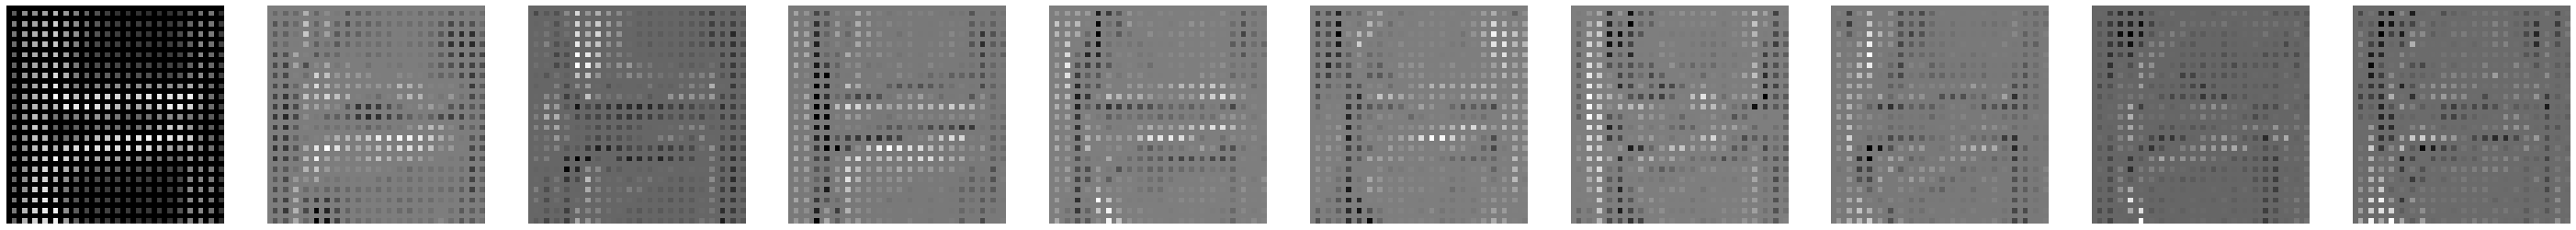

In [4]:
# 用 train data
hog_masks = []
for im in train_data:
    fd, hog_im_roi = hog(im, orientations=4, pixels_per_cell=(2, 2), cells_per_block=(2, 2), visualize=True)
    hog_im_roi = hog_im_roi.reshape(1,-1)     # ravel the mask 
    hog_masks.append(hog_im_roi)
    
hog_masks = np.concatenate(hog_masks,axis=0).T  # (42*42,N) where 42*42 is the nb of positions in mask and N is the nb of masks
pca = PCA(n_components = hog_masks.shape[-1])
pca.fit(hog_masks)
N = 10
pca = PCA(n_components = N)              # then we decide to take the first N masks
hog_masks = pca.fit_transform(hog_masks)
windows = hog_masks.T.reshape(N,im_shape[0],im_shape[1])
weighted_windows = [windows[i] for i in range(N)]
weighted_windows = [weighted_windows, pca.explained_variance_ratio_[0:N]]
print(windows.shape)
print(weighted_windows[0][0].shape,weighted_windows[1][0])

plt.figure(figsize = (N*5,5))
for i in range(N):
    plt.subplot(1,N,i+1)
    plt.imshow(weighted_windows[0][i],cmap='gray')
    plt.axis('off')
    
plt.show()

# 定义class

operating...
done.


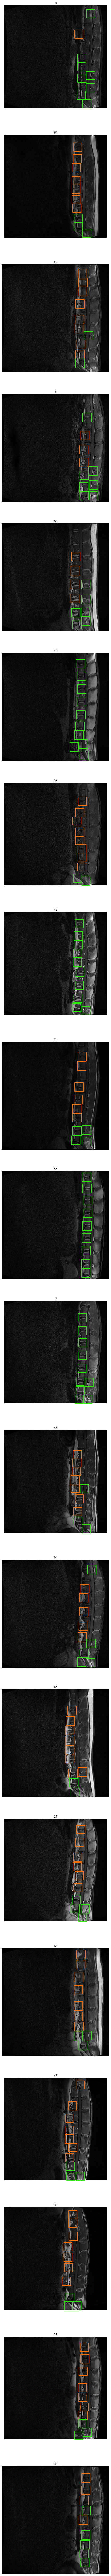

Model evaluation: TP:  470  | FP:  251  | precision score:  0.651872399445215


In [6]:
class Detection():
    def __init__(self, weighted_windows, ims, input_size, pos):
        self.weighted_windows = weighted_windows
        self.window_size = weighted_windows[0][0].shape
        self.ims = ims
        self.input_size = input_size
        self.pos = pos
 
    def operate(self, n):
        print('operating...')
        self.n_indices = []
        for i, im in enumerate(ims):
            self.n_indices.append(self.find_roi(im, self.weighted_windows, n))
        print('done.')
            
    def draw_figure(self, inds):
        inds = list(inds)
        plt.figure(figsize = (10,10*len(inds)))
        colormap = plt.cm.gist_ncar   
        colors = [colormap(i) for i in np.linspace(0, 1, 4)] 
        for i, ind in enumerate(inds):
            im = self.ims[ind]
            indices = self.n_indices[ind]
            gt,g = self.ground_truth(im, self.pos[i], indices)
            
            plt.subplot(len(inds),1,i+1)
            plt.imshow(im,cmap='gray')
            [self.plot_roi_from_indice(im, self.window_size, indices[i], colors[2]) for i in range(len(indices)) if gt[i]==1] 
            [self.plot_roi_from_indice(im, self.window_size, indices[i], colors[1]) for i in range(len(indices)) if gt[i]==0]
            #[self.plot_roi_from_indice(im, self.window_size, g[i], colors[3]) for i in range(len(g))]
            plt.axis('off')
            plt.title(ind)
        plt.show()
        
    def evaluation(self):
        TPs = []
        FPs = []
        for i,im in enumerate(self.ims):
            indices = self.n_indices[i]
            gt,g = self.ground_truth(im, self.pos[i], indices)
            # 考虑到evaluation 的 indice全部都预测为正，因此只需要计算TP和FP
            TPs.append(np.sum(gt))
            FPs.append(gt.shape[0] - np.sum(gt))
            
        # 查准率, 指的是在所有预测正的里面正确的比例
        print('Model evaluation: TP: ', np.array(TPs).sum().astype(np.int), ' | FP: ', np.array(FPs).sum().astype(np.int), 
            ' | precision score: ',np.array(TPs).sum()/(np.array(FPs).sum()+np.array(TPs).sum()))

    def ground_truth(self, im, pos, indices, tol = 5):
        dir_labels = r'D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\positive ROI'
        dir_labels = os.path.join(dir_labels,'T'+str(pos[0])+' SAG')
        dir_labels = os.path.join(dir_labels,str(pos[1])+'_'+str(pos[2]))
        rois_dict = read_roi_zip(dir_labels + '.zip')
        axis_ens = np.array(rois_dict_to_axis(rois_dict))
        #axis_ens = reduce_size_from_indice(axis_ens, modify_label_size)

        gt_true = np.zeros(indices.shape[0],)  # 第一列是gt,第二列是preds
        gt = []
        for (x,y,_,_) in axis_ens:
            x += ceil((label_size[1]-modify_label_size[1])/2)
            y += floor((label_size[0]-modify_label_size[0])/2)
            gt.append([y,x])
        gt = np.array(gt)

        for i,(test_y,test_x) in enumerate(indices):
            for (gt_y,gt_x) in gt:
                if (test_y-gt_y)< tol and (test_x-gt_x)< tol:
                    gt_true[i] = 1
                    continue
                    
        return gt_true,gt
    
    def largest_indices(self, ary, n):
        """Returns the n largest indices from a numpy array."""
        flat = ary.flatten()
        indices = np.argpartition(flat, -n)[-n:]
        indices = indices[np.argsort(-flat[indices])]
        return np.unravel_index(indices, ary.shape)

    def NCC(self, im, weighted_windows, n):
        """NNC template match"""
        N = len(self.weighted_windows[1])
        h_window,w_window = self.weighted_windows[0][0].shape
        h_im,w_im = im.shape

        results = np.zeros((N, h_im-h_window+1, w_im-w_window+1))

        for n_window, window in enumerate(self.weighted_windows[0]):
            window_mean = np.mean(window)
            for i in range(results.shape[1]):
                for j in range(results.shape[2]): 
                    im_piece = im[i:i+window.shape[0],j:j+window.shape[1]]-np.mean(im[i:i+window.shape[0],j:j+window.shape[1]])
                    results[n_window,i,j] = np.sum(np.abs(im_piece*(window-window_mean)))

        results = np.average(results, axis=0, weights=weighted_windows[1])
        size_results = results.shape[0]*results.shape[1]
        n_indices = self.largest_indices(results,size_results)
        n_indices = [[n_indices[0][i], n_indices[1][i]] for i in range(size_results)]

        window_size = self.weighted_windows[0][0].shape
        chosen_indices = self.remove_overlap_indices(n_indices, window_size, n)

        return chosen_indices

    def remove_overlap_indices(self, n_indices, window_size, k):
        """remove the indices of which the windows are overlapped and keep only k indices"""
        chosen_indices = []
        i = 0
        chosen_indices.append(n_indices[i])
        while k - 1 > 0 and i < len(n_indices):
            is_chosen = True
            for indice in chosen_indices:
                if self.is_overlap(indice, n_indices[i], window_size):
                    is_chosen = False
            if is_chosen:
                chosen_indices.append(n_indices[i])
                k -= 1
            i += 1
        return chosen_indices

    def plot_roi_from_indice(self, ims, input_size, indice, if_label = False):
        """Plot roi from one indice"""
        h, w = input_size
        x, y = indice[1], indice[0] 
        X = [x,x,x+w,x+w,x]
        Y = [y,y+h,y+h,y,y]
        c = np.array([X,Y]).T
        if if_label == False:
            plt.plot(c[:, 0], c[:, 1], '-b', lw=2)
        else:
            plt.plot(c[:, 0], c[:, 1], '-b', lw=2, color = if_label) 

    def is_overlap(self, indice1, indice2, window_size):
        """Verify if two windows overlap"""
        h, w = window_size
        x1, y1 = indice1[1], indice1[0]
        x2, y2 = indice2[1], indice2[0]

        if y2 >= y1 + h or y2 <= y1 - h or x2 >= x1 + w or x2 <= x1 - w:
            return False
        else:
            return True

    def find_roi(self, im, weighted_windows, n):
        """Find region of interest of image im by using windows"""
        im_rectangle, l, r = find_rect(im, orientations=8, pixels_per_cell=(512,4), cells_per_block=(2,2))
        fd, im_hog = hog(im_rectangle[:,l:r], orientations=8, pixels_per_cell=(2,2), cells_per_block=(1,1), visualize=True)

        n_indices = self.NCC(im_hog, weighted_windows, n)
        n_indices = np.array(n_indices)
        n_indices[:,1] += l
        
        return n_indices

detection_machine = Detection(weighted_windows, ims_T1, modify_label_size, pos)
detection_machine.operate(n=10)
detection_machine.draw_figure(random.sample(list(np.arange(len(ims_T1))),20))
detection_machine.evaluation()

# trial

In [18]:
T2_fs = [r"D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\IRM_process\Brebis1\1\T2_TSE_SAG\IM-0028-0004.dcm",
        r"D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\IRM_process\Brebis2\1\T2_TSE_SAG\IM-0001-0004.dcm",
        r"D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\IRM_process\Brebis3\1\T2_TSE_SAG\IM-0001-0004.dcm",
        r"D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\IRM_process\Brebis4\1\T2_TSE_SAG\IM-0001-0004.dcm",
        r"D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\IRM_process\Brebis5\2\T2_TSE_SAG\IM-0001-0004.dcm",]
T2 = []
for i in range(5):
    f = T2_fs[i]
    ds = pydicom.dcmread(f)      # dcm format         
    im = ds.pixel_array          # array 这里train data是（512，512） dtype = int16
    T2.append(im)
    
trainT2_data_p = np.array(T2)

In [20]:
root = r"D:\课件\ECN第二年DATASIM\Projet\projet mapping segmentation\ROI for NCC"
print(type(os.listdir(root)))
print(os.listdir(root))

<class 'list'>
['1-1.zip', '2-1.zip', '3-1.zip', '4-1.zip', '5-2.zip']


In [21]:
rois_indices = []
for roi_zip_path in os.listdir(root):
    roi_zip_path = os.path.join(root,roi_zip_path)
    rois = read_roi_zip(roi_zip_path)
    rois_indices.append(np.array(rois_dict_to_axis(rois)))

rois_indices = np.array(rois_indices)
print(rois_indices.shape)
print(rois_indices[0])

(5,)
[[361 148  36  21]
 [364 210  36  21]
 [358  85  36  21]
 [363 271  36  21]
 [359 336  36  21]
 [354 400  36  21]]


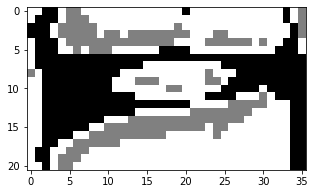

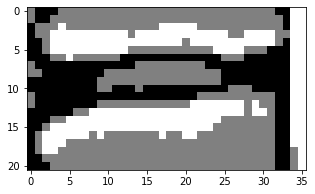

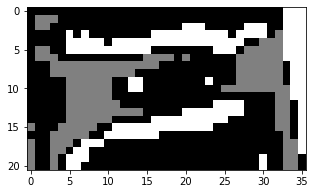

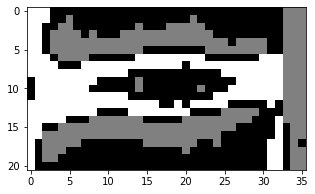

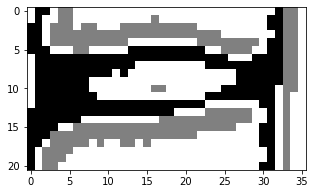

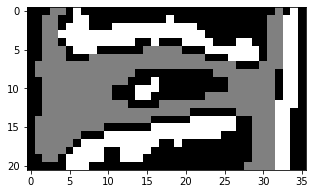

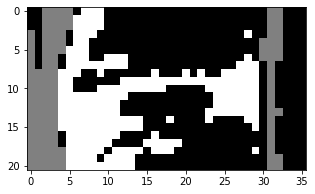

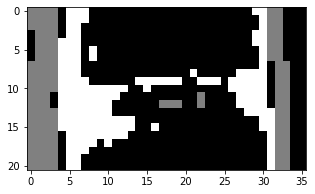

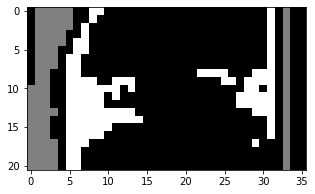

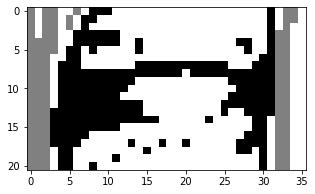

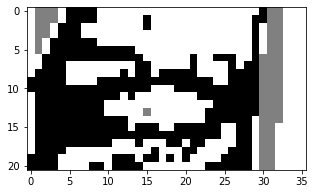

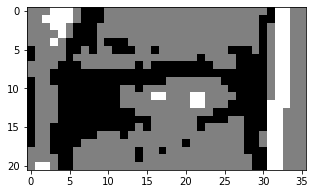

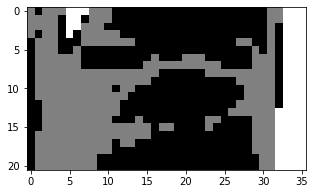

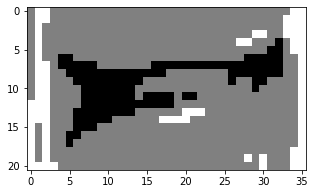

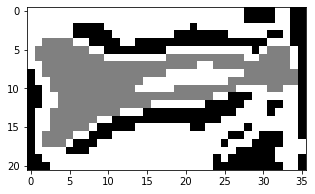

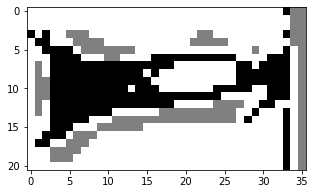

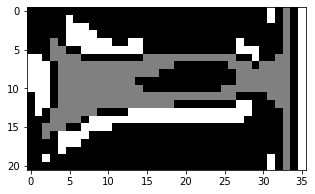

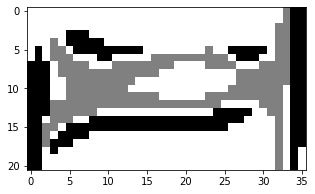

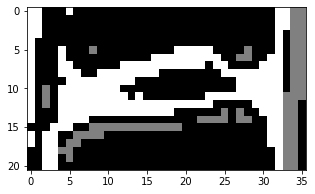

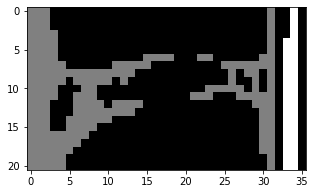

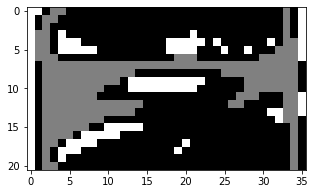

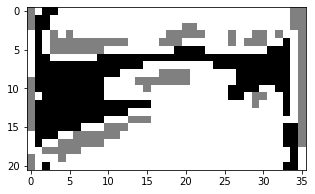

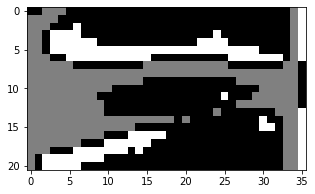

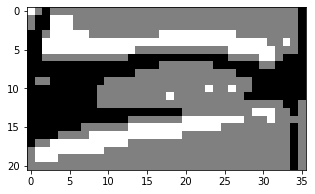

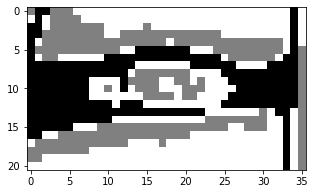

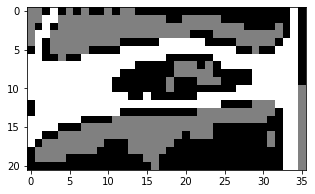

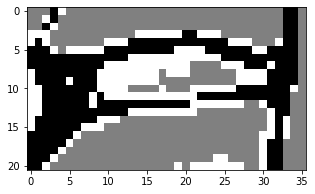

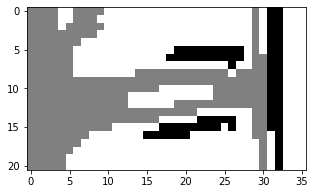

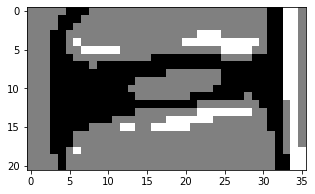

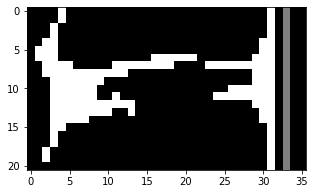

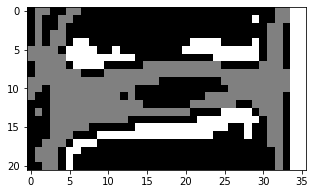

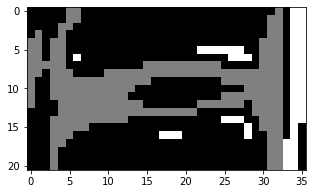

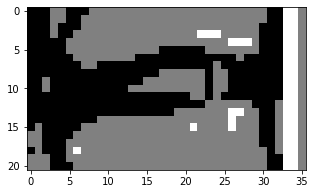

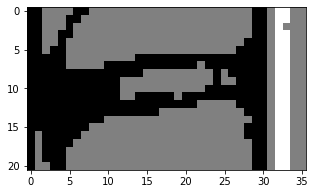

In [25]:
for im_rois in ims_rois:
    for im_roi in im_rois:
        pred = gmm(im_roi, im_roi.shape, 3)
        plt.figure(figsize=(5,5))
        plt.imshow(pred,cmap='gray')
        plt.show()

In [26]:
f = r".\IM-0029-0004.dcm"
ds = pydicom.dcmread(f)      # dcm format         
im = ds.pixel_array          # array 这里train data是（512，512） dtype = int16

plt.figure(figsize=(10,10))
io.imshow(im,cmap='gray')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '.\\IM-0029-0004.dcm'

In [27]:
def gmm(im,n):
    data = im.ravel()[:,np.newaxis]

    model = GaussianMixture(n_components = n)
    model.fit(data)
    label_pred = model.predict(data)
    label_pred = label_pred.reshape(im.shape)
    return label_pred

def get_rois(im,rects):
    im_rois = []
    for i,(x,y,w,h) in enumerate(rects):
        im_rois.append(im[y:y+h,x:x+w])
    return im_rois

ims_rois = []
for i,im in enumerate(trainT2_data_p):
    im_rois = get_rois(im,rois_indices[i])
    ims_rois.append(im_rois)
ims_rois = np.array(ims_rois)

print(len(ims_rois))
print(len(rois_indices))
print(ims_rois[0][0].shape)

5
5
(21, 36)


(756, 34)
[7.88007048e-01 5.29319896e-02 3.50380281e-02 2.34643058e-02
 2.14122802e-02 1.12542147e-02 9.01746333e-03 6.39807906e-03
 5.48503074e-03 5.29953035e-03 4.65917284e-03 4.14378673e-03
 3.89958566e-03 3.37397574e-03 2.99081591e-03 2.81912346e-03
 2.39959022e-03 2.07645660e-03 1.99798285e-03 1.79063642e-03
 1.47622611e-03 1.29066019e-03 1.24588087e-03 1.09622896e-03
 1.02366628e-03 9.50027797e-04 9.35294128e-04 7.27204622e-04
 6.40831245e-04 5.97045725e-04 5.48901869e-04 4.39988666e-04
 3.12815607e-04 2.56131694e-04]
(756, 6)
(6, 21, 36)


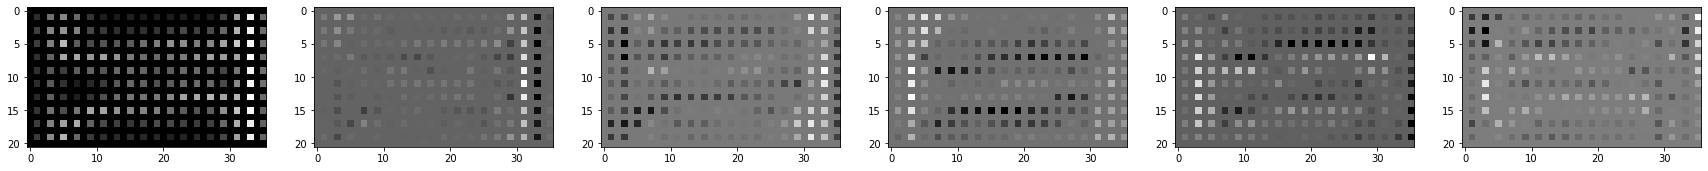

In [31]:
hog_masks = []
for im_rois in ims_rois:
    for im_roi in im_rois:
        fd, hog_im_roi = hog(im_roi, orientations=4, pixels_per_cell=(2, 2),
                        cells_per_block=(2, 2), visualize=True)
        hog_im_roi = hog_im_roi.reshape(1,-1)     # ravel the mask 
        hog_masks.append(hog_im_roi)
        #plt.figure()
        #plt.imshow(hog_im_roi,cmap='gray')
        #plt.show()
hog_masks = np.concatenate(hog_masks,axis=0).T    # (756,34) where 756 is the nb of positions in mask and 34 is the nb of masks
print(hog_masks.shape)

pca = PCA(n_components = hog_masks.shape[-1])
pca.fit(hog_masks)
print(pca.explained_variance_ratio_)     # we find that N.1 mask takes 0.78 while the next four take more than 1%
#print(pca.explained_variance_)

N = 6

pca = PCA(n_components = N)              # then we decide to take the first N masks
hog_masks = pca.fit_transform(hog_masks)
print(hog_masks.shape)
plt.figure(figsize = (30,6))

windows = hog_masks.T.reshape(N,ims_rois[0][0].shape[0],ims_rois[0][0].shape[1])
weighted_windows = [windows[i] for i in range(N)]
weighted_windows = [weighted_windows, pca.explained_variance_ratio_[0:N]]
print(windows.shape)

for i in range(N):
    plt.subplot(1,N,i+1)
    plt.imshow(weighted_windows[0][i],cmap='gray')

In [ ]:
nb = np.random.randint(ims_T2.shape[0])
im = ims_T2[nb]

def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

def NCC(im, weighted_windows, n):
    """NNC template match"""
    N = len(weighted_windows[1])
    h_window,w_window = weighted_windows[0][0].shape
    h_im,w_im = im.shape
    
    results = np.zeros((N, h_im-h_window+1, w_im-w_window+1))
    
    for n_window, window in enumerate(weighted_windows[0]):
        window_mean = np.mean(window)
        for i in range(results.shape[1]):
            for j in range(results.shape[2]): 
                im_piece = im[i:i+window.shape[0],j:j+window.shape[1]]-np.mean(im[i:i+window.shape[0],j:j+window.shape[1]])
                results[n_window,i,j] = np.sum(np.abs(im_piece*(window-window_mean)))
    
    results = np.average(results, axis=0, weights=weighted_windows[1])
    size_results = results.shape[0]*results.shape[1]
    n_indices = largest_indices(results,size_results)
    n_indices = [[n_indices[0][i], n_indices[1][i]] for i in range(size_results)]
    
    window_size = weighted_windows[0][0].shape
    print(window_size)
    chosen_indices = remove_overlap_indices(n_indices, window_size, n)
    return chosen_indices

def remove_overlap_indices(n_indices, window_size, k):
    """remove the indices of which the windows are overlapped and keep only k indices"""
    chosen_indices = []
    i = 0
    chosen_indices.append(n_indices[i])
    while k - 1 > 0 and i < len(n_indices):
        is_chosen = True
        for indice in chosen_indices:
            if is_overlap(indice, n_indices[i], window_size):
                is_chosen = False
        if is_chosen:
            chosen_indices.append(n_indices[i])
            k -= 1
        i += 1
    return chosen_indices
    
def plot_roi_from_indice(im, window_size, indice):
    """Plot roi from one indice"""
    h, w = window_size
    x, y = indice[1], indice[0] #注意：由于indices里面服从array的axis规律，第一个是第零轴，是纵坐标，但是在画图中，plot的第一个是横坐标
    X = [x,x,x+w,x+w,x]
    Y = [y,y+h,y+h,y,y]
    c = np.array([X,Y]).T
    plt.plot(c[:, 0], c[:, 1], '-b', lw=2)

def is_overlap(indice1, indice2, window_size):
    """Verify if two windows overlap"""
    h, w = window_size
    x1, y1 = indice1[1], indice1[0]
    x2, y2 = indice2[1], indice2[0]
    
    if y2 >= y1 + h or y2 <= y1 - h or x2 >= x1 + w or x2 <= x1 - w:
        return False
    else:
        return True

def find_roi(im, weighted_windows, n):
    """Find region of interest of image im by using windows"""
    im_rectangle, l, r = find_rect(im, orientations=8, pixels_per_cell=(512,4), cells_per_block=(2,2))
    fd, im_hog = hog(im_rectangle[:,l:r], orientations=8, pixels_per_cell=(2,2), cells_per_block=(1,1), visualize=True)
    
    n_indices = NCC(im_hog, weighted_windows, n)
    n_indices = [[n_indices[i][0], n_indices[i][1]+l] for i in range(n)]      
    n_indices = np.array(n_indices)
    
    plt.figure(figsize = (10,10))
    plt.imshow(im,cmap='gray')
    window_size = weighted_windows[0][0].shape
    [plot_roi_from_indice(im, window_size, n_indices[i,:]) for i in range(n)]
    plt.show()
    print(n_indices)
    
find_roi(im, weighted_windows, 10)